# Rolling Planning mit Tardiness (Max)

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 26)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics
import src.models.lp.tardiness_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [2]:
max_time = 60*60*4 # 4h
max_time = 60*15 # 15 min

## Generierung des Datensatzes für 8 Tage (Ankunft)

In [3]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 8, u_b_mmax= 0.94, shuffle = True)
df_jobs_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,81.32
2,Job_002,101.67
3,Job_003,142.01
4,Job_004,177.21
...,...,...
177,Job_177,11443.10
178,Job_178,11447.34
179,Job_179,11460.98
180,Job_180,11478.69


In [4]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0.00,1748.0
1,Job_001,81.32,2339.0
2,Job_002,101.67,2616.0
3,Job_003,142.01,3041.0
4,Job_004,177.21,1917.0
...,...,...,...
177,Job_177,11443.10,13284.0
178,Job_178,11447.34,13837.0
179,Job_179,11460.98,13718.0
180,Job_180,11478.69,13227.0


## Params

In [5]:
# fix
day_length = 1440
horizon_days = 1

In [6]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [7]:
day_numb = 0

In [8]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 2880

In [9]:
# I)
df_jssp_curr, df_times_curr = rolling_schedule.filter_jobs_by_arrival_window(df_jobs, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
315,Job_031,5,M1,28
316,Job_031,6,M6,46
317,Job_031,7,M5,46
318,Job_031,8,M7,72


In [10]:
df_times_curr 

,Job,Arrival,Deadline
0,Job_000,0.00,1748.0
1,Job_001,81.32,2339.0
2,Job_002,101.67,2616.0
3,Job_003,142.01,3041.0
4,Job_004,177.21,1917.0
...,...,...,...
27,Job_027,1390.30,3776.0
28,Job_028,1391.02,3139.0
29,Job_029,1410.87,3150.0
30,Job_030,1423.44,3172.0


### Scheduling

In [11]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_max_tardiness(df_jssp_curr, df_times_curr, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.075)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 10000

Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 5345
  Anzahl Constraints      : 10304

Scheduling-Dauer: 3 Minuten und 3.25 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1748.0,M0,0.00,29.0,29.00,0
1,Job_000,1,0.00,1748.0,M1,29.00,78.0,107.00,0
2,Job_000,2,0.00,1748.0,M2,107.00,9.0,116.00,0
3,Job_000,3,0.00,1748.0,M3,116.00,36.0,152.00,0
4,Job_000,4,0.00,1748.0,M4,152.00,49.0,201.00,0
...,...,...,...,...,...,...,...,...,...
315,Job_024,5,1238.36,4137.0,M8,3815.68,52.0,3867.68,0
316,Job_024,6,1238.36,4137.0,M7,3889.00,85.0,3974.00,0
317,Job_024,7,1238.36,4137.0,M3,3974.00,98.0,4072.00,0
318,Job_024,8,1238.36,4137.0,M9,4072.00,22.0,4094.00,0


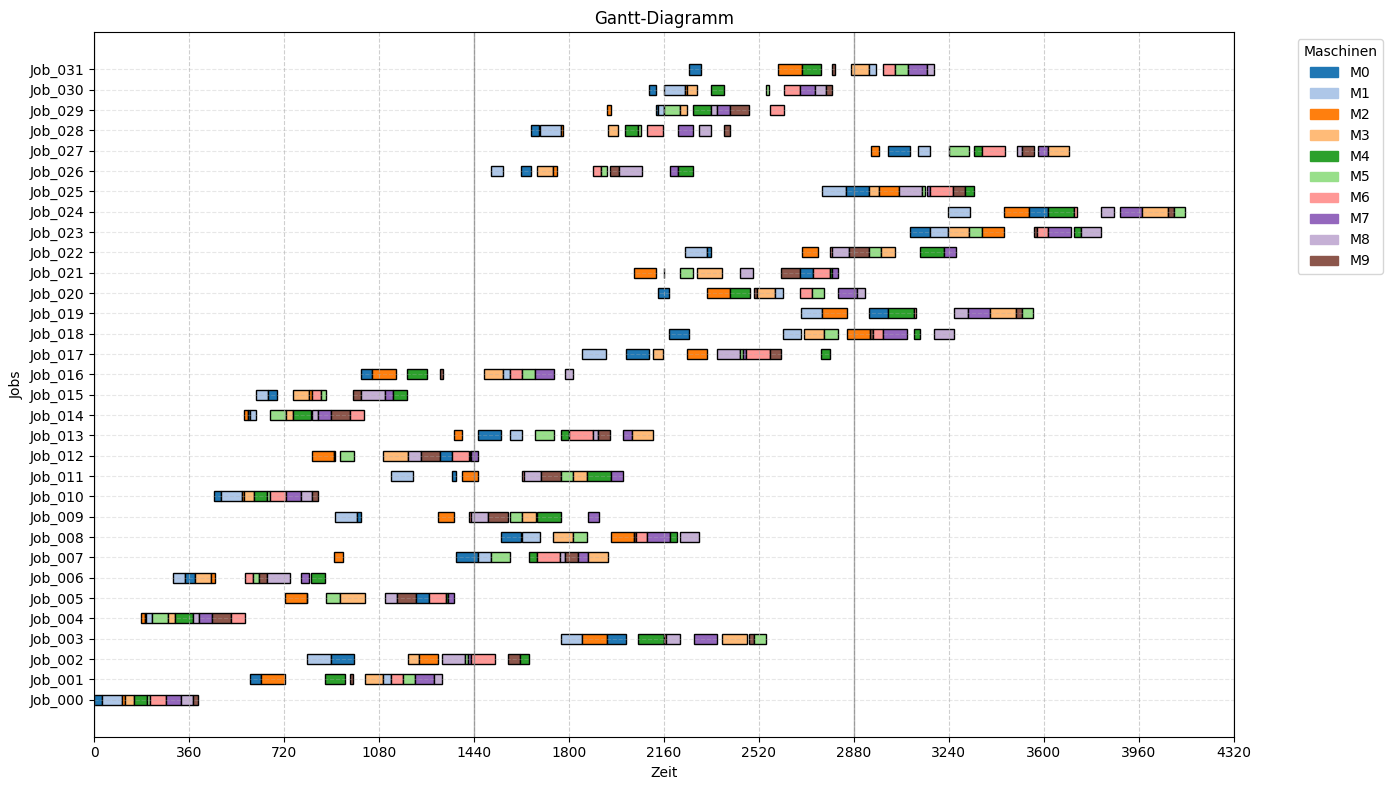

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [13]:
show.count_column_grouped(df_plan, 'Tardiness')

label
0            320
0 - 60         0
60 - 120       0
120 - 180      0
>180           0
Name: count, dtype: int64

### Simulation

In [14]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:15:13] Job_000 finished on M0 (after 15 minutes 13 seconds)
[00:29:00] Job_000 started on M1
[01:55:43] Job_000 finished on M1 (after 86 minutes 44 seconds)
[01:55:43] Job_000 started on M2
[02:04:03] Job_000 finished on M2 (after 08 minutes 19 seconds)
[02:04:03] Job_000 started on M3
[02:37:38] Job_000 finished on M3 (after 33 minutes 35 seconds)
[02:37:38] Job_000 started on M4
[02:57:12] Job_004 started on M2
[03:12:21] Job_004 finished on M2 (after 15 minutes 09 seconds)
[03:12:21] Job_004 started on M0
[03:18:07] Job_004 finished on M0 (after 05 minutes 46 seconds)
[03:18:07] Job_004 started on M1
[03:36:21] Job_000 finished on M4 (after 58 minutes 43 seconds)
[03:36:21] Job_000 started on M5
[03:36:37] Job_004 finished on M1 (after 18 minutes 30 seconds)
[03:42:57] Job_000 finished on M5 (after 06 minutes 36 seconds)
[03:42:57] Job_004 started on M5
[03:42:57] Job_000 started on M6
[04:43:42] Job_000 finished on M6 (after 60 minutes 45 second

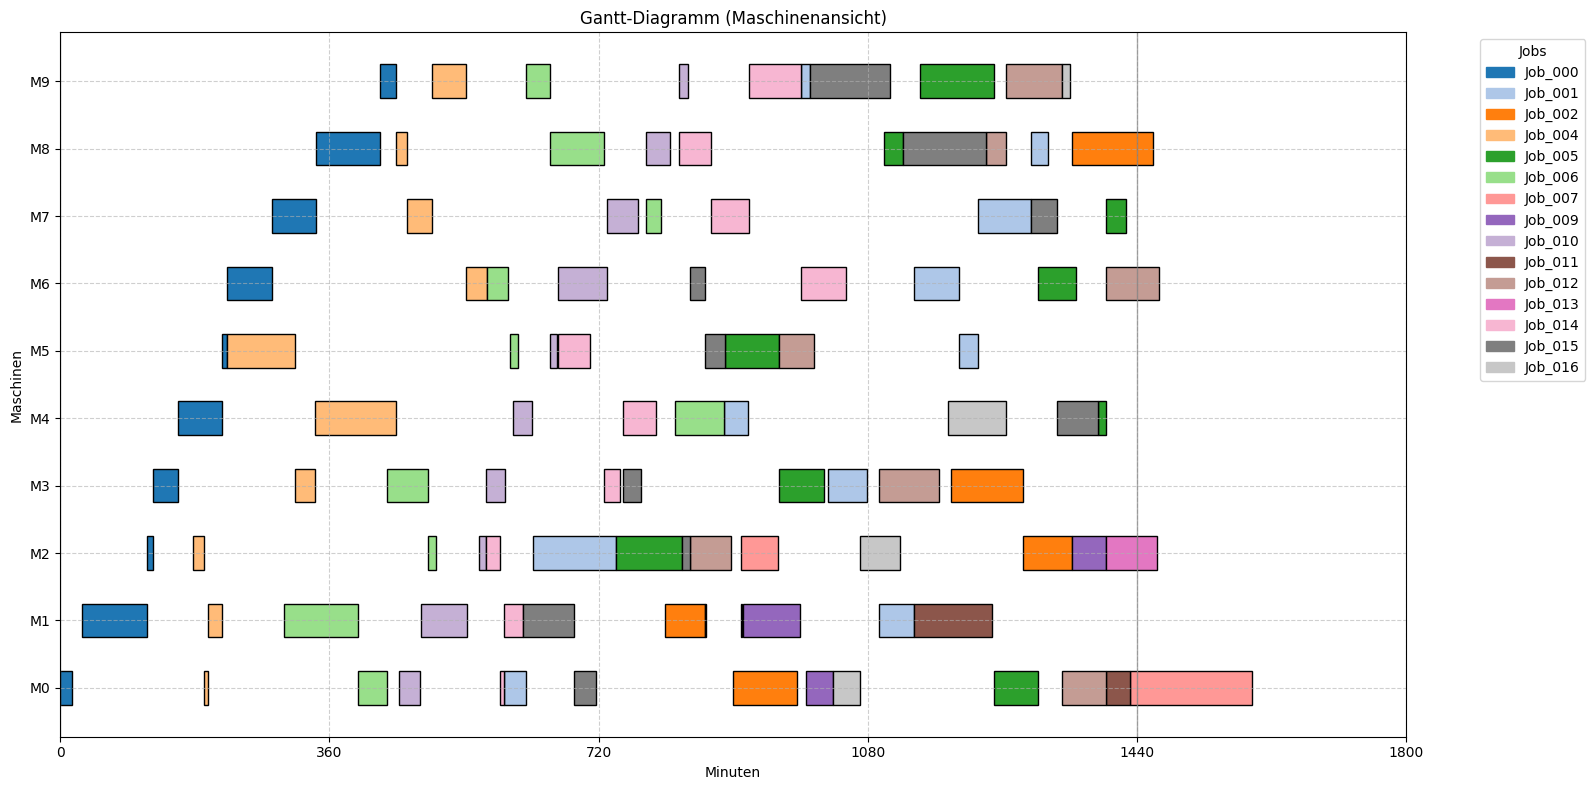

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_011,2,498.24,M2,1395.68,61.0
1,Job_002,5,101.67,M5,1407.68,10.0
2,Job_002,6,101.67,M7,1417.68,12.0
3,Job_009,3,410.96,M6,1422.68,7.0
4,Job_012,8,505.40,M4,1423.68,6.0
...,...,...,...,...,...,...
210,Job_024,5,1238.36,M8,3815.68,52.0
211,Job_024,6,1238.36,M7,3889.00,85.0
212,Job_024,7,1238.36,M3,3974.00,98.0
213,Job_024,8,1238.36,M9,4072.00,22.0


#### Export

In [17]:
data_path = get_path("data", "lp_tardiness")

In [18]:
df_jssp.to_csv(data_path / "02_tardiness_all_jssp.csv", index = False)
df_jobs.to_csv(data_path / "02_tardiness_all_times.csv", index = False)

In [19]:
df_plan.to_csv(data_path / "02_tardiness_init_plan.csv", index = False)
df_execution.to_csv(data_path / "02_tardiness_execution.csv", index = False)
df_undone.to_csv(data_path / "02_tardiness_init_undone.csv", index = False)